# Migraine Buddy .csv Parser

The .csv reports generated by MigraineBuddy are not super useful in and of themselves because most of the data isn't timestamped unless you use the log file.

This notebook assumes you are using the logfile for tracking medication using the built in macros in migraine buddy ("I took this drug button").  It assumes that you are tracking starting time and ending time as well as pain level through migraine buddy.

In [35]:
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt
import calmap

plt.style.use('seaborn')

print( pd.__version__ )
print( calmap.__version__ )

1.0.3
0.0.8


In [36]:
# Any missing pain levels are likely 3: 'Can do most activities'
default_pain_level = 3
today = pd.to_datetime('today').normalize()
meds = ['ubrelvy', 'rizatriptan', 'sumatriptan', 'zofran', 'cefaly', 'nerivio', 'tylenol', 'advil', 'nurtec', 'aimovig']
# Any periods of time to mark on the charts (med use, etc)
# Use the following columns:
# "start", "end", "label", "description"
dtypes = [datetime.datetime, datetime.datetime, str, str]
notable_periods = pd.read_csv(
    "notable_periods.csv")

notable_periods['start'] = pd.to_datetime( notable_periods['start'], dayfirst=True )
notable_periods['end'] = pd.to_datetime( notable_periods['end'], dayfirst=True )

# Assume blank ends are on-going periods
notable_periods['end'] = notable_periods['end'].fillna(today)

notable_periods.reset_index()

notable_periods

,start,end,label,description,events
0,2021-05-07,2021-10-07,Emgality,NaN,NaN
1,2021-02-14,2021-04-27,Propranolol,NaN,NaN
2,2021-03-29,2021-06-08,Topiramate,NaN,NaN
3,2021-12-10,2022-02-01,Aimovig,NaN,NaN
4,2021-11-01,2022-02-01,Duloxetine,NaN,{ '2022-01-15': '40mg'}
5,2021-09-20,2022-02-01,Fitness,NaN,{ '2022-01-23': '22lbs lost'}


Import the MB .csv export to a dataframe and handle some basic data cleaning.

In [37]:
migraines = pd.read_csv(
    "MigraineBuddy_20201104_20220202_1643771347182_53291870.csv", 
    converters={ 'Notes': lambda x: x.splitlines() },
    skiprows=3,
    keep_default_na=False )

# Fix column types
migraines['Started'] = pd.to_datetime( migraines['Started'], dayfirst=True )
migraines['Lasted'] = pd.to_timedelta( migraines['Lasted'], errors='coerce' )
migraines['Ended'] = migraines['Started'] + migraines['Lasted']
migraines['Pain Level'] = pd.to_numeric( migraines['Pain Level'], errors='ignore' )

pd.set_option('display.max_rows', 10)
#pd.set_option('display.max_rows', None)
#migraines.sort_values('#')

Let's try to parse out the log entries since this is where the most rich timestamped data can be found.  This is a blob of text in a column and is finicky.  Really only works if you use the MB macros for everything.

In [38]:
# Remove blank log entries.
migraines['Notes'] = migraines['Notes'].apply( (lambda notes: [ s for s in notes if s]) )
# Separate the note field lines into a separate data frame.
log = migraines.explode( 'Notes')[['#', 'Started', 'Notes']]
# extract the date/text from the log entry
log[['Date', 'Entry']] = log['Notes'].str.extract('(?P<Date>[A-Za-z]{3} [0-9]{1,2}, [0-9]{4} at [0-9]{1,2}:[0-9]{2} [A-Za-z]{2})[: ]*(?P<Entry>.*)$') 

# fix entries
log['Date'] = log['Date'].replace( {'Dec 16, 2020 at 19:44 AM':  'Dec 16, 2020 at 10:44 AM' }, regex=True )
log['Date'] = log['Date'].replace( {'Oct 12, 2020 at 5:99 PM':  'Oct 12, 2020 at 5:19 PM' }, regex=True )

log['Date'] = pd.to_datetime( log['Date'] )

# reset the log index column
log = log.reset_index(drop=True)

# Flag medications and remove the text label
log['Medication'] = np.where( log['Entry'].str.contains( 'I took this drug:', na=False), True, False )
log['Entry'] = log['Entry'].str.replace( 'I took this drug: ', '')

# Uncomment these to check the data import

#print( migraines.head() )
#print( migraines.info() )


#print( log.head() )
#print( log.info() )

In [39]:
# Add a date range column
migraines['Date Range'] = migraines[migraines['Ended'].notnull()].apply(
    lambda x: pd.date_range(x["Started"].date(), x["Ended"].date()), axis=1
)
# expand so we have row per day
daily_migraines = migraines.explode( 'Date Range')[['#', 'Pain Level', 'Date Range', 'Started', 'Lasted', 'Ended']]
daily_migraines['Pain Level'] = daily_migraines['Pain Level'].fillna( default_pain_level )
daily_migraines = daily_migraines.sort_values( ['Date Range', 'Pain Level'], ascending=False ).drop_duplicates( subset='Date Range', keep='first' )

(<Figure size 800x550 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10ac6a630>,
       dtype=object))

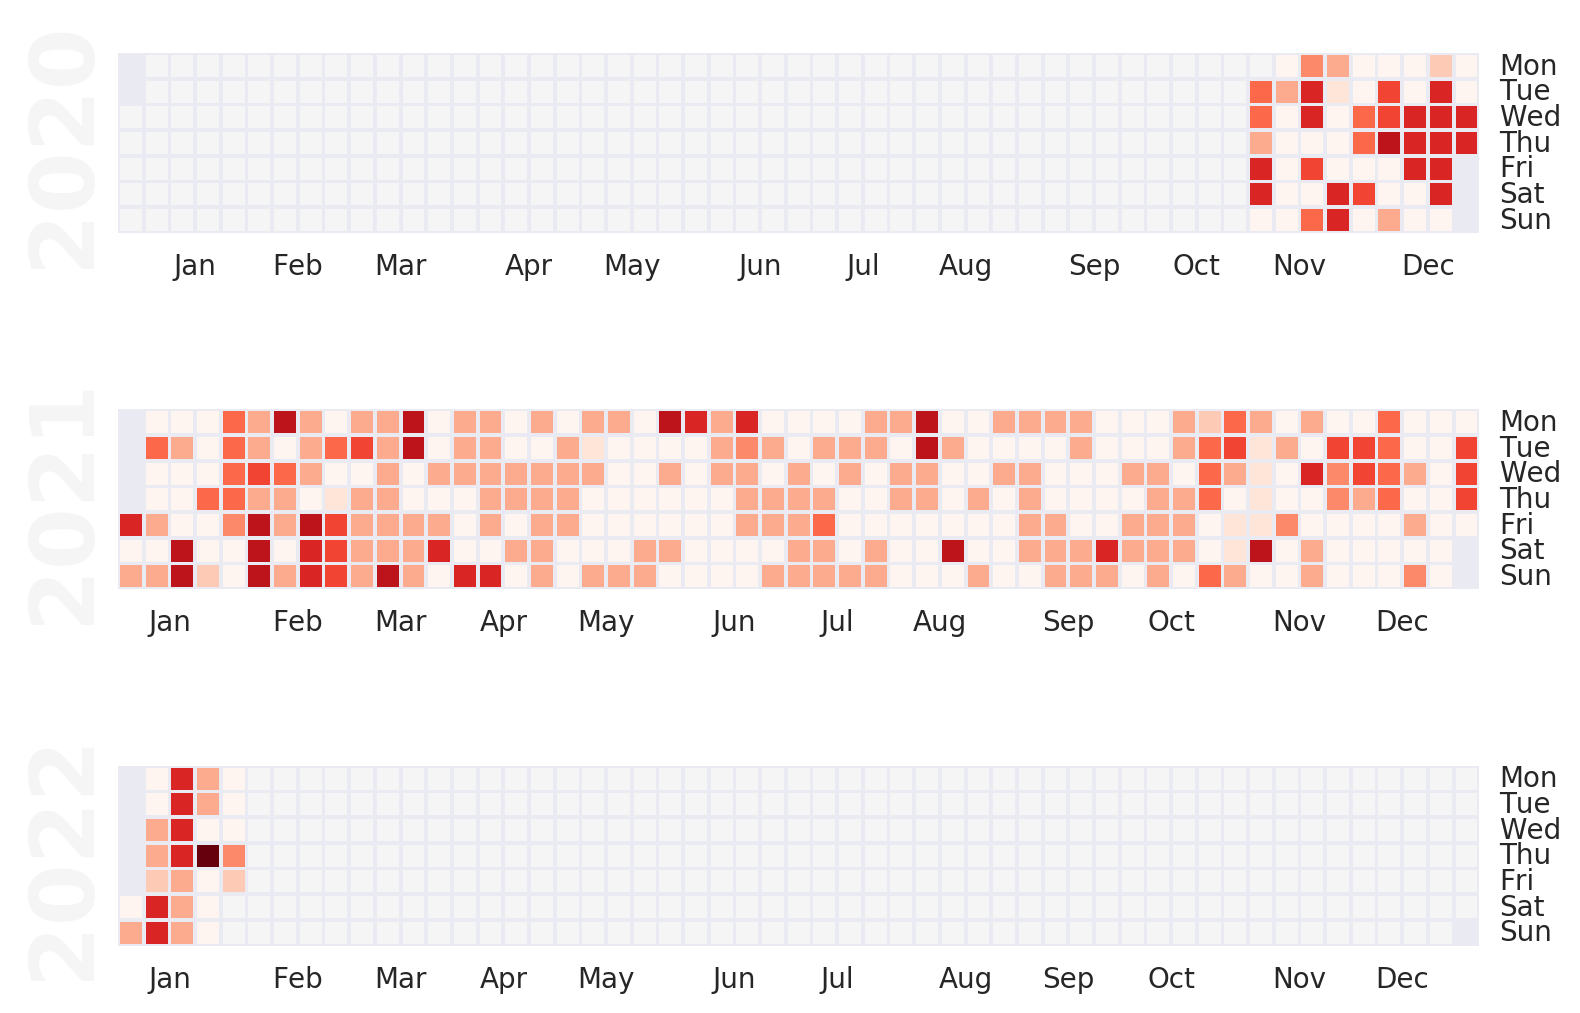

In [40]:
heatmap = daily_migraines[daily_migraines['Ended'].notnull()]
heatmap = heatmap.set_index('Date Range')

calmap.calendarplot( heatmap['Pain Level'] )

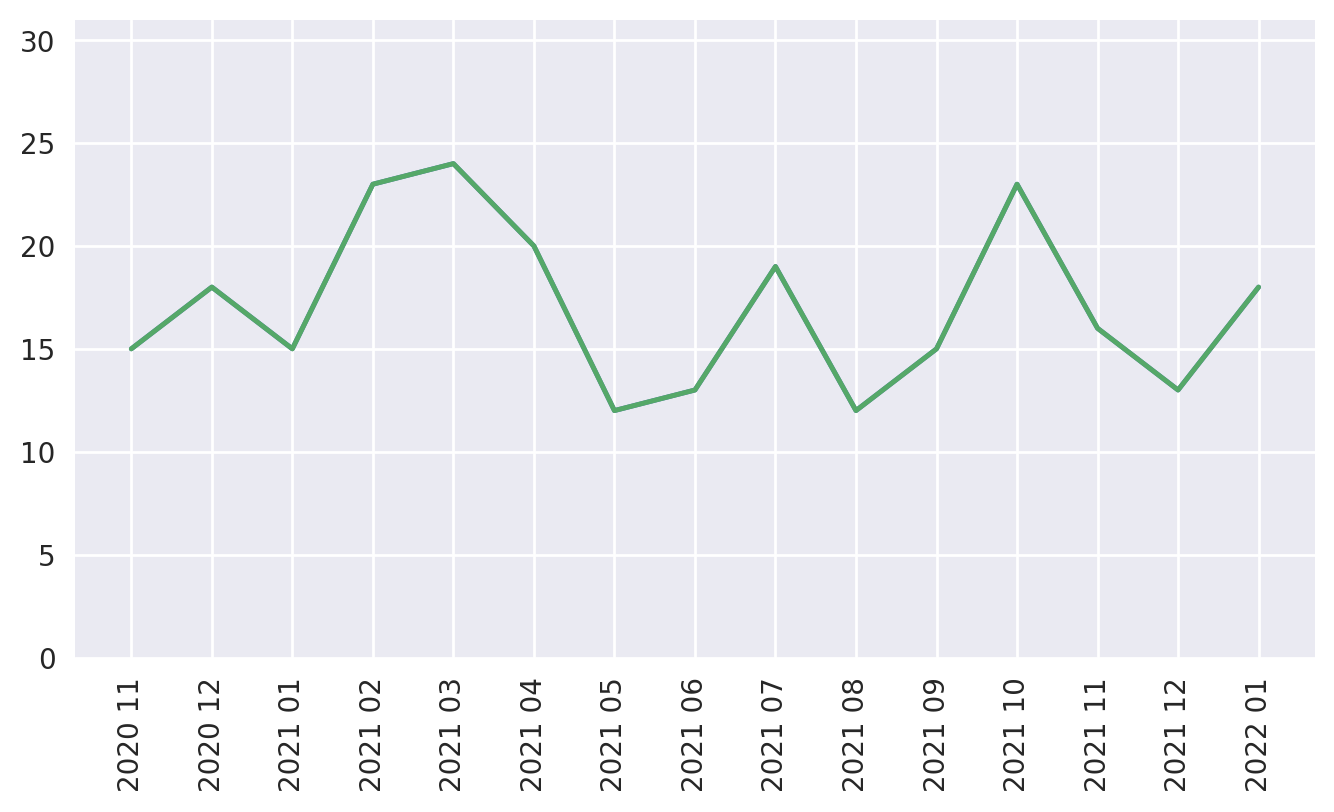

In [41]:
#Plot migraine days per month
fig, axs = plt.subplots()      
fig.subplots_adjust(bottom=0.3)
plt.xticks(rotation=90)
plt.ylim( bottom=0, top=31 )
plt.plot( daily_migraines[['Date Range', '#']].groupby( daily_migraines['Date Range'].dt.strftime('%Y %m')).count() )

In [42]:
pd.set_option('display.max_rows', None)
daily_migraines['#'].groupby( daily_migraines['Date Range'].dt.strftime('%Y %m'), as_index=True).count()

Date Range
2020 11    15
2020 12    18
2021 01    15
2021 02    23
2021 03    24
2021 04    20
2021 05    12
2021 06    13
2021 07    19
2021 08    12
2021 09    15
2021 10    23
2021 11    16
2021 12    13
2022 01    18
Name: #, dtype: int64

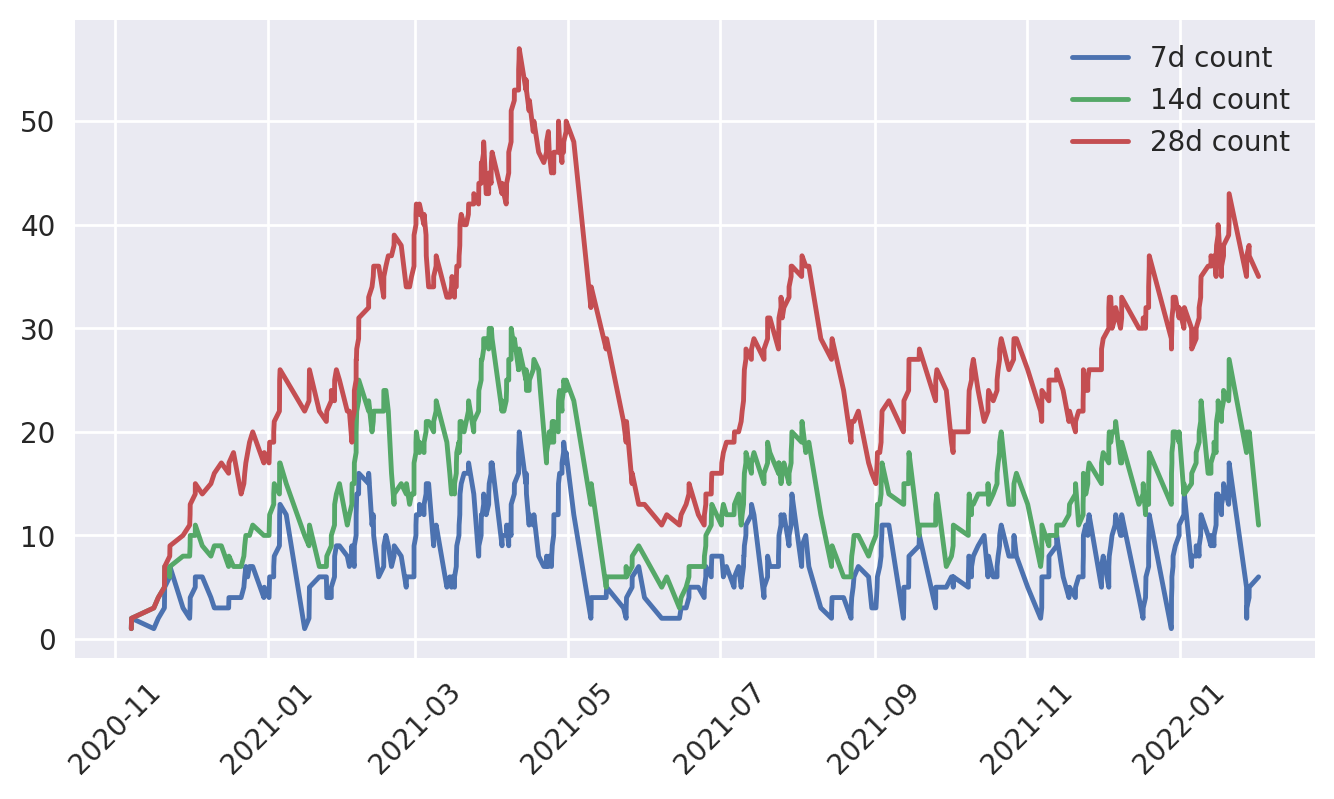

In [43]:
meds = log[log['Medication'] == True].copy()
meds2 = meds.set_index('Date')
meds2 = meds2.sort_index()
meds2['Occ'] = 1

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.3)
plt.xticks(rotation=45)
plt.plot(meds2['Occ'].rolling( '7d', min_periods=1 ).count(), label='7d count')
plt.plot(meds2['Occ'].rolling( '14d', min_periods=1 ).count(), label='14d count')
plt.plot(meds2['Occ'].rolling( '28d', min_periods=1 ).count(), label='28d count')

#plt.axvline( pd.Timestamp('2021-11-01'), color='r')
#plt.hlines( y=10, xmin=pd.Timestamp('2021-08-01'), xmax=pd.Timestamp('2021-11-01') )
ax.legend()

In [45]:

#for index,period in notable_periods.iterrows():
    #plt.axvspan( period['start'], period['end'], alpha=.2, label=period['label'])    


In [46]:
meds[['Name', 'Q']] = meds['Entry'].str.extract( "((?P<Q>\d+(mg|ml)) )?(?P<Name>[A-Za-z]+)")[['Name', 'Q']]
meds['Month'] = pd.to_datetime(meds['Date']).dt.strftime('%m')
meds['Year'] = pd.to_datetime(meds['Date']).dt.strftime('%Y')
meds['YM'] = pd.to_datetime(meds['Date']).dt.strftime('%Y-%m')
meds['Name'] = meds['Name'].str.lower()
#meds

pd.set_option('display.max_columns', None)
pd.pivot_table( meds, index='YM', columns='Name', values='Q', aggfunc='count')

Name,advil,aleve,benadryl,boswellia,cefaly,ginger,lidocaine,m,nerivio,nurtec,ondancetron,sumatriptan,timolol,topiramate,tylenol,ubrelvy,zofran,zyrtec
YM,,,,,,,,,,,,,,,,,,
2020-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,1.0,NaN
2020-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2.0,12.0,0.0,NaN
2021-01,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,3.0,13.0,6.0,NaN
2021-02,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,7.0,NaN,NaN,NaN,NaN,4.0,9.0,4.0,NaN
2021-03,6.0,1.0,NaN,NaN,0.0,3.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,7.0,7.0,1.0,0.0
2021-04,7.0,1.0,NaN,1.0,NaN,3.0,NaN,NaN,0.0,8.0,NaN,1.0,NaN,1.0,3.0,8.0,1.0,NaN
2021-05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.0,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN
2021-06,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2021-07,7.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,11.0,NaN,NaN,NaN,NaN,3.0,1.0,5.0,NaN
